In [1]:
from Favorfit_remove_bg import inference as remove_bg
from Favorfit_image_to_text import clip_image_to_text

rmbg_model = remove_bg.call_model("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
import random
from PIL import Image
from PIL.ImageOps import expand

from diffusers.utils import make_image_grid
from utils import *

import torch
from diffusers import KandinskyV22PriorPipeline
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_split import KandinskyV22ControlnetPipeline

from diffusers.models.controlnet_kandinsky import ControlNetModel as ControlNetModelKandinsky


In [3]:
# pr_path = "./image/not_pot.jpg"
# tp_path = "./template/yellow.jpg"
pr_path = "/home/mlfavorfit/Downloads/sample/composition/5_pr.jpg"
tp_path = "/home/mlfavorfit/Downloads/sample/composition/5_tp.jpg"

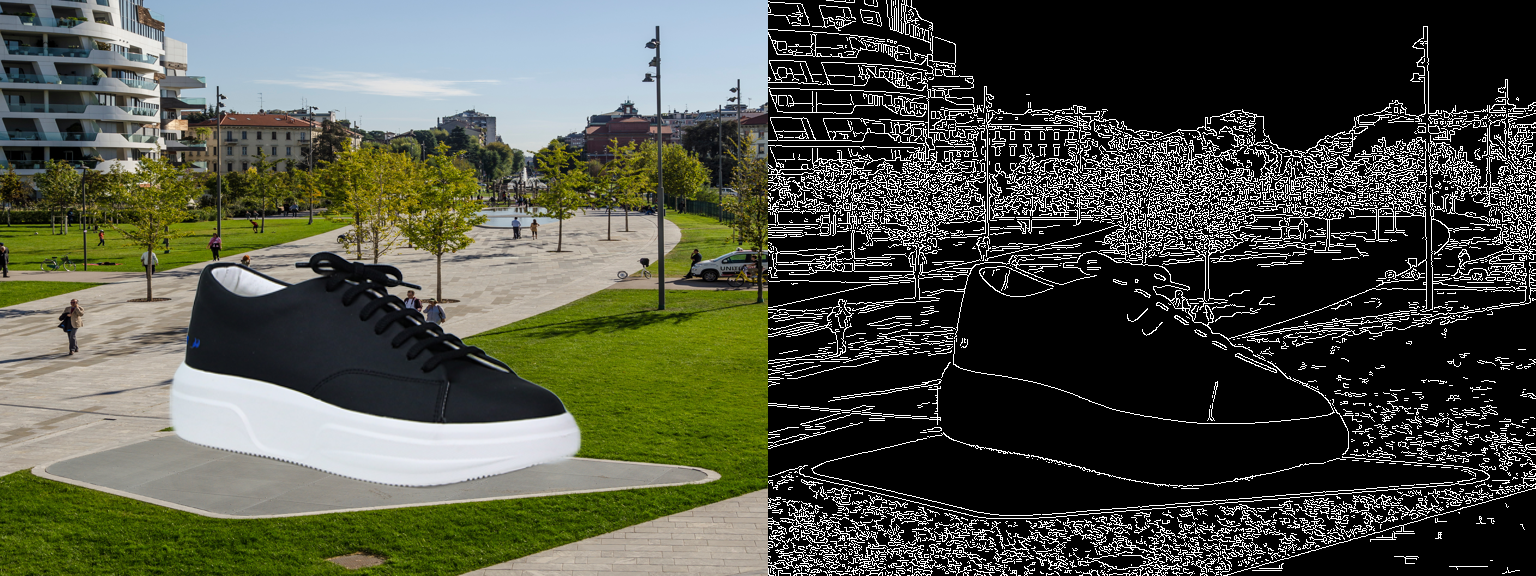

In [9]:
init_image = resize_store_ratio(Image.open(pr_path))
mask = remove_bg.inference(init_image, rmbg_model).convert("L")

def transform_image_and_mask(border, scale_x, scale_y):
    global init_image, mask
    
    ori_width, ori_height = init_image.size

    # 확대
    new_width = int(init_image.width * scale_x)
    new_height = int(init_image.height * scale_y)
    init_image = init_image.resize((new_width, new_height))
    mask = mask.resize((new_width, new_height))
    
    var_width = (new_width - ori_width)/2
    var_height = (new_height - ori_height)/2

    # 이미지 잘라내기
    init_image = init_image.crop((var_width, var_height, new_width-var_width, new_height-var_height))
    mask = mask.crop((var_width, var_height, new_width-var_width, new_height-var_height))

    init_image = expand(init_image, border=border)
    mask = expand(mask, border=border)
    
    init_image = init_image.resize((round(cur/64) * 64 for cur in init_image.size))
    mask = mask.resize((round(cur/64) * 64 for cur in mask.size))
    

transform_image_and_mask(border=(0,80,0,0), scale_x=1.2, scale_y=1.2)

tp = center_crop_and_resize(Image.open(tp_path), target_size=init_image.size)

init_image = composing_image(tp, init_image, mask.convert("RGB"))
canny_image = make_canny_condition(init_image)
object_image = make_outpaint_condition(init_image, mask.convert("RGB"))
width, height = init_image.size
make_image_grid([init_image, canny_image], rows=1, cols=2)

In [10]:
decoder_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-decoder"
prior_model_path = "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior"

controlnet_kandinsky = ControlNetModelKandinsky.from_pretrained(
    decoder_model_path, subfolder="controlnet/canny", torch_dtype=torch.float16
).eval()

prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
    prior_model_path,
    use_safetensors=True,
    torch_dtype=torch.float16,
)

pipeline = KandinskyV22ControlnetPipeline.from_pretrained(
    decoder_model_path,
    controlnet=controlnet_kandinsky,
    torch_dtype=torch.float16,
)

The config attributes {'center_input_sample': False} were passed to ControlNetModel, but are not expected and will be ignored. Please verify your config.json configuration file.
Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]
The config attributes {'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer']} were passed to KandinskyV22ControlnetPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer']} are not expected by KandinskyV22ControlnetPipeline and will be ignored.
Loading pipeline components...: 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


In [11]:
important_keywords = ", natural materials :: high detail, behance. polished, trending on textures. com, clean 3 d render, raytraced 3d set design, raytracing shadows, image on the store website"
caption = clip_image_to_text.inference(object_image, clip_model, mode="simple")
caption

caption2 = clip_image_to_text.inference(init_image, clip_model, mode="fast", remove_color=True)
caption2

'the grass is , inflatable future shoes, sneaker design, floating over a city sidewalk, futuristic balenciaga sneakers, stepping on the city, platform game, inspi by Edi Rama, stylish shoe design, hyper real render, 3 d hyper realistic render, 3 d ue 5, palace floating in heaven, official product photo, concept image, adventure hyper realistic render'

In [15]:
prompt = f"shadow, {caption}, {caption2}"
negative_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts, nsfw, paintings, sketches, text, watermark, username, spikey"

seed = random.randint(0,10000)

In [16]:
prior_pipeline = prior_pipeline.to("cuda")
pipeline = pipeline.to("cuda")

generator = torch.Generator(device="cuda").manual_seed(seed)

with torch.autocast("cuda", torch.float16):
    prior_output = prior_pipeline(
        prompt=prompt, 
        negative_prompt=negative_prompt, 
        generator=generator,
    )

    generated_image = pipeline(
        image=init_image,
        control_image=canny_image,
        **prior_output,
        height=height,
        width=width,
        num_inference_steps=30,
        strength=0.3,
        guidance_scale=2.5,
        controlnet_scale=1.0,
        generator=generator,
    ).images[0]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['realistic render', '<|endoftext|><|endoftext|>']
100%|██████████| 9/9 [00:01<00:00,  7.05it/s]


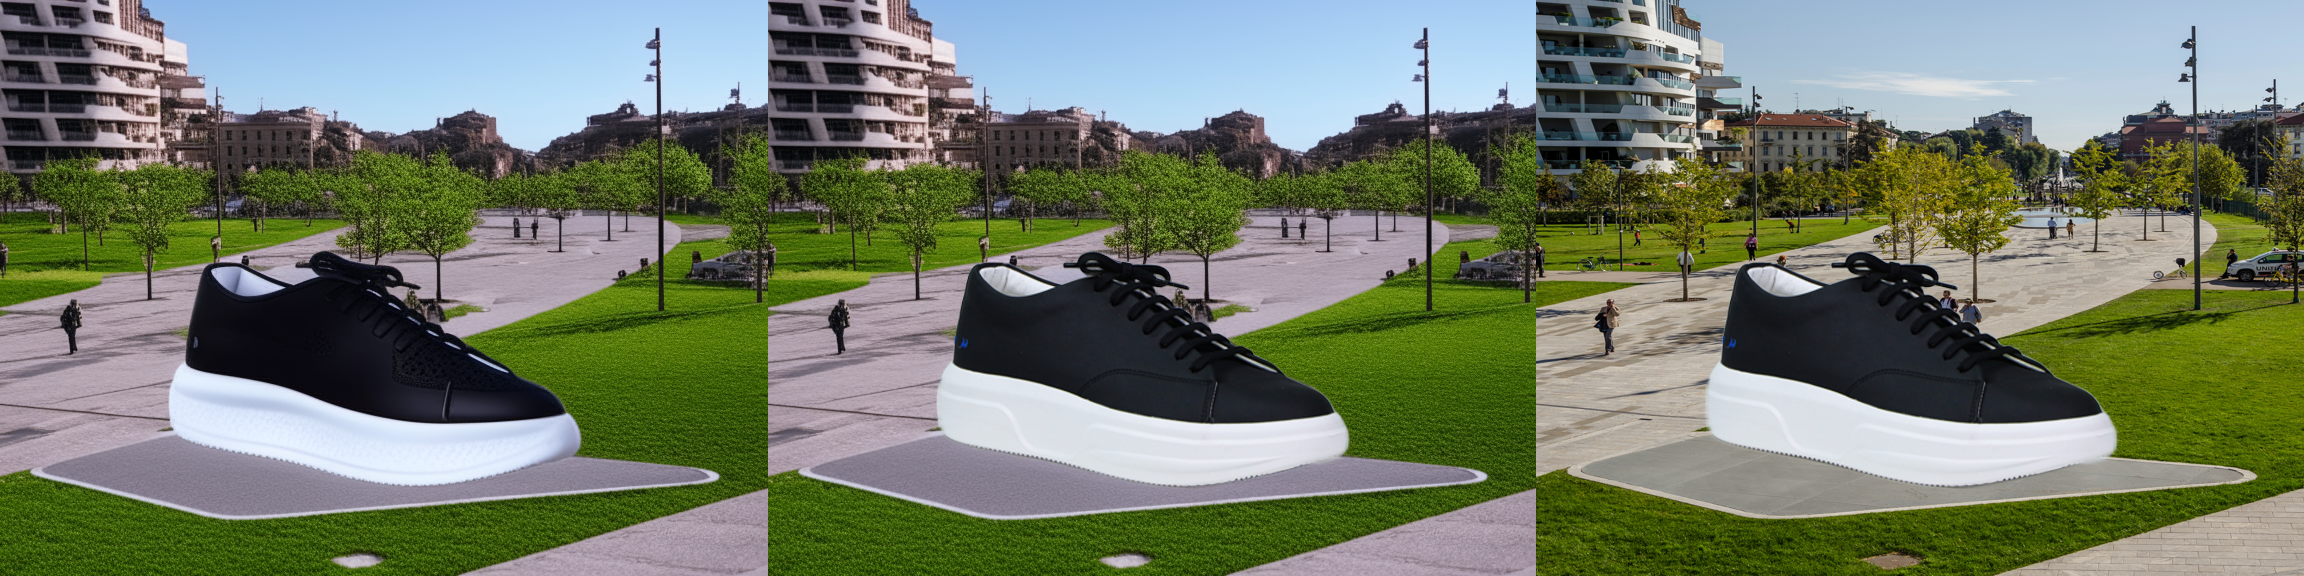

In [17]:
composed_image = composing_image(generated_image, init_image, mask.convert("RGB"))
make_image_grid([generated_image, composed_image, init_image], rows=1, cols=3)

In [18]:
generated_image = composed_image

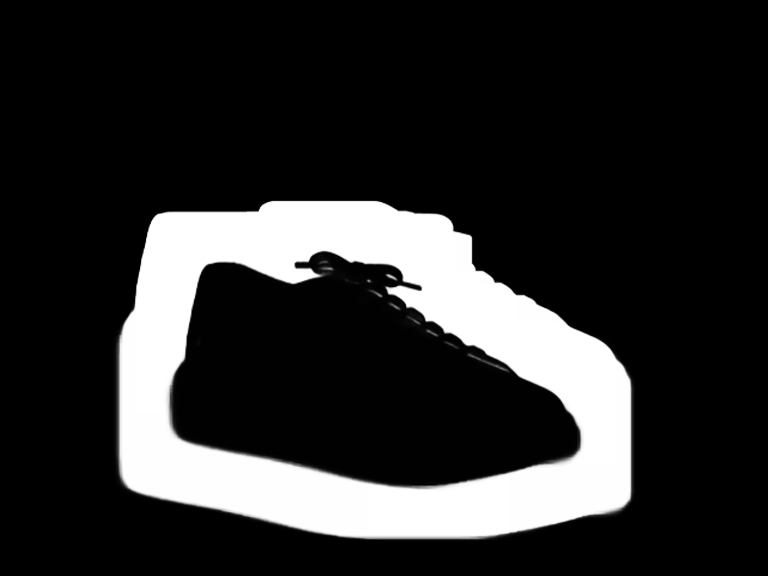

In [19]:
import numpy as np
from PIL.ImageOps import invert

expand_mask = cv2.dilate(np.array(mask.convert("L")), np.ones((3,3)), iterations=50)
expand_mask

mask_np = np.array(invert(mask.convert("L")))
exp_mask_np = np.array(expand_mask)

combine_mask = mask_np * (exp_mask_np/255) + exp_mask_np * (1-exp_mask_np/255)
combine_mask = Image.fromarray(combine_mask).convert("RGB")
combine_mask

In [20]:
from diffusers.pipelines.kandinsky2_2.pipeline_kandinsky2_2_inpainting import KandinskyV22InpaintPipeline

prior_pipeline = KandinskyV22PriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16, use_safetensors=True).to("cuda")
pipeline = KandinskyV22InpaintPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16, use_safetensors=True).to("cuda")

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


In [21]:
prompt = f"shadow, " + caption
negative_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts, nsfw, paintings, sketches, text, watermark, username, spikey"

seed = random.randint(0,10000)

In [22]:
generator = torch.Generator(device="cuda").manual_seed(seed)
prior_output = prior_pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    generator=generator
    )
output_image = pipeline(image=generated_image, 
                        mask_image=combine_mask, 
                        **prior_output, 
                        height=height, 
                        width=width, 
                        num_inference_steps=20,
                        strength=0.2,
                        guidance_scale=3.0,
                        generator=generator).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 10.49it/s]


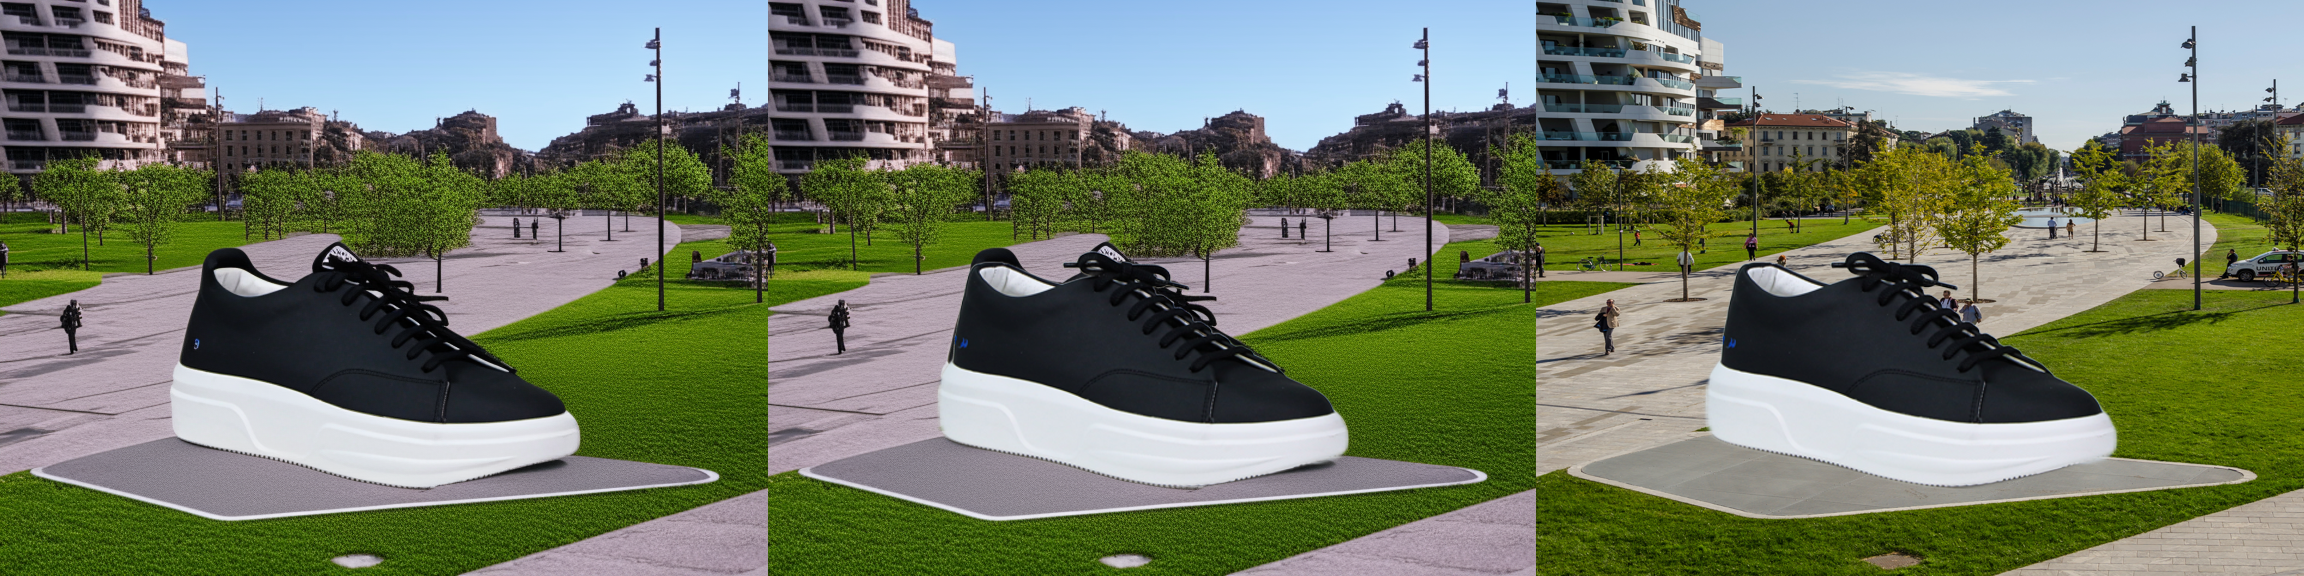

In [23]:
composed_image = composing_image(init_image, output_image, invert(mask).convert("RGB"))
make_image_grid([output_image, composed_image, init_image], rows=1, cols=3)

In [1]:
import random
from PIL import Image
from PIL.ImageOps import expand
from PIL.ImageOps import invert

import torch
import numpy as np
from diffusers import KandinskyV22PriorPipeline
from diffusers.utils import logging
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_split import KandinskyV22ControlnetPipeline
from diffusers.pipelines.kandinsky2_2.pipeline_kandinsky2_2_inpainting import KandinskyV22InpaintPipeline
from diffusers.models.controlnet_kandinsky import ControlNetModel as ControlNetModelKandinsky

from utils import *

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
try:
    del prior_pipeline
    del pipeline
    del controlnet_kandinsky
    del rmbg_model
    del clip_model
    torch.cuda.empty_cache()
except Exception as e:
    pass

logging.set_verbosity_error()

In [3]:
from Favorfit_remove_bg import inference as remove_bg
from Favorfit_image_to_text import clip_image_to_text

rmbg_model = remove_bg.call_model("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
def load_model():
    controlnet_kandinsky = ControlNetModelKandinsky.from_pretrained(
        "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-decoder", 
        subfolder="controlnet/canny", 
        torch_dtype=torch.float16
    ).eval()

    prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
        "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-prior",
        torch_dtype=torch.float16,
        use_safetensors=True,
    )
    prior_pipeline.set_progress_bar_config(disable=True)

    controlnet_pipeline = KandinskyV22ControlnetPipeline.from_pretrained(
        "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-decoder",
        controlnet=controlnet_kandinsky,
        torch_dtype=torch.float16,
    )
    controlnet_pipeline.set_progress_bar_config(disable=True)

    inpaint_pipeline = KandinskyV22InpaintPipeline.from_pretrained(
        "kandinsky-community/kandinsky-2-2-decoder-inpaint", 
        torch_dtype=torch.float16, 
        use_safetensors=True)
    inpaint_pipeline.set_progress_bar_config(disable=True)
    
    return {
        "prior_pipeline":prior_pipeline,
        "controlnet_pipeline":controlnet_pipeline,
        "inpaint_pipeline":inpaint_pipeline,
    }

models = load_model()

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  8.61it/s]


In [5]:
def massage_image(init_image, mask, models):
    width, height = init_image.size

    canny_image = make_canny_condition(init_image)
    object_image = make_outpaint_condition(init_image, mask.convert("RGB"))

    caption = clip_image_to_text.inference(object_image, clip_model, mode="simple")
    caption2 = clip_image_to_text.inference(init_image, clip_model, mode="fast", remove_color=True)

    prompt = f"shadow, {caption}, {caption2}"
    negative_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts, nsfw, paintings, sketches, text, watermark, username, spikey"

    prior_pipeline = models["prior_pipeline"].to("cuda")
    controlnet_pipeline = models["controlnet_pipeline"].to("cuda")

    seed = random.randint(0,10000)
    generator = torch.Generator(device="cuda").manual_seed(seed)

    with torch.autocast("cuda", torch.float16):
        prior_output = prior_pipeline(
            prompt=prompt, 
            negative_prompt=negative_prompt, 
            generator=generator,
        )

        generated_image = controlnet_pipeline(
            image=init_image,
            control_image=canny_image,
            **prior_output,
            height=height,
            width=width,
            num_inference_steps=30,
            strength=0.2,
            guidance_scale=2.5,
            controlnet_scale=1.0,
            generator=generator,
        ).images[0]
    
    generated_image = composing_image(generated_image, init_image, mask.convert("RGB"))

    models["controlnet_pipeline"] = controlnet_pipeline.to("cpu")
    del controlnet_pipeline
    torch.cuda.empty_cache()
    

    expand_mask = cv2.dilate(np.array(mask.convert("L")), np.ones((3,3)), iterations=50)
    mask_np = np.array(invert(mask.convert("L")))
    exp_mask_np = np.array(expand_mask)

    combine_mask = mask_np * (exp_mask_np/255) + exp_mask_np * (1-exp_mask_np/255)
    combine_mask = Image.fromarray(combine_mask).convert("RGB")

    
    prompt = f"shadow, " + caption

    inpaint_pipeline = models["inpaint_pipeline"].to("cuda")

    prior_output = prior_pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        generator=generator
        )
    output_image = inpaint_pipeline(image=generated_image, 
                            mask_image=combine_mask, 
                            **prior_output, 
                            height=height, 
                            width=width, 
                            num_inference_steps=20,
                            strength=0.2,
                            guidance_scale=3.0,
                            generator=generator).images[0]
    
    models["prior_pipeline"] = prior_pipeline.to("cpu")
    models["inpaint_pipeline"] = inpaint_pipeline.to("cpu")
    del prior_pipeline
    del inpaint_pipeline
    torch.cuda.empty_cache()

    output_image = composing_image(output_image, init_image, mask.convert("RGB"))

    return output_image

In [29]:
# pr_path = "./image/outpaint/kamil.jpg"
# tp_path = "./template/blue.jpg"
pr_path = "/home/mlfavorfit/Downloads/sample/composition/5_pr.jpg"
tp_path = "/home/mlfavorfit/Downloads/sample/composition/5_tp.jpg"

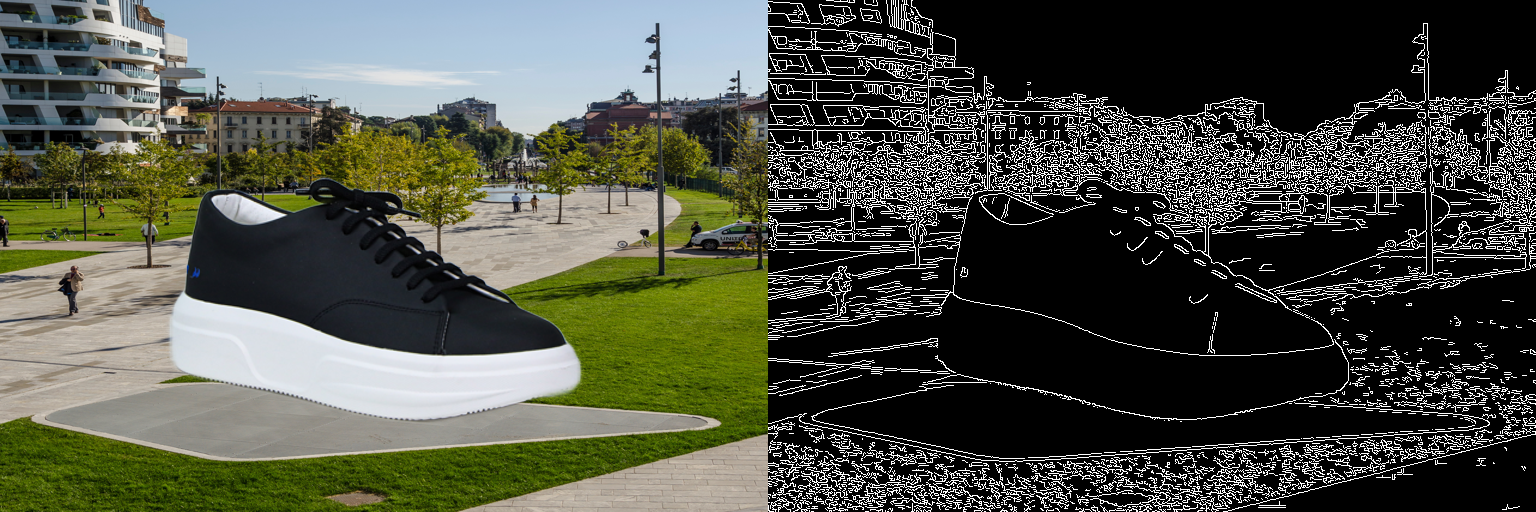

In [12]:
from diffusers.utils import make_image_grid

init_image = resize_store_ratio(Image.open(pr_path))
mask = remove_bg.inference(init_image, rmbg_model).convert("L")

def transform_image_and_mask(border, scale_x, scale_y):
    global init_image, mask
    
    ori_width, ori_height = init_image.size

    # 확대
    new_width = int(init_image.width * scale_x)
    new_height = int(init_image.height * scale_y)
    init_image = init_image.resize((new_width, new_height))
    mask = mask.resize((new_width, new_height))
    
    var_width = (new_width - ori_width)/2
    var_height = (new_height - ori_height)/2

    # 이미지 잘라내기
    init_image = init_image.crop((var_width, var_height, new_width-var_width, new_height-var_height))
    mask = mask.crop((var_width, var_height, new_width-var_width, new_height-var_height))

    init_image = expand(init_image, border=border)
    mask = expand(mask, border=border)
    
    init_image = init_image.resize((round(cur/64) * 64 for cur in init_image.size))
    mask = mask.resize((round(cur/64) * 64 for cur in mask.size))
    

transform_image_and_mask(border=(0,0,0,0), scale_x=1.2, scale_y=1.2)

tp = center_crop_and_resize(Image.open(tp_path), target_size=init_image.size)

init_image = composing_image(tp, init_image, mask.convert("RGB"))
canny_image = make_canny_condition(init_image)
object_image = make_outpaint_condition(init_image, mask.convert("RGB"))
width, height = init_image.size
make_image_grid([init_image, canny_image], rows=1, cols=2)

In [13]:
init_image.save("./image/massage/pr/shoe.jpg")
mask.save("./image/massage/mask/shoe_mask.jpg")

In [6]:
import os
from tqdm import tqdm
from glob import glob

pr_path = sorted(glob("./image/massage/pr/*"))
mask_path = sorted(glob("./image/massage/mask/*"))

In [7]:
save_dir = "./output/massage/"
num_image_per_prompt = 50

progress_bar = tqdm(range(0, len(pr_path) * num_image_per_prompt), desc="Running inference...")
for pr, mask in zip(pr_path, mask_path):
    target_dir = os.path.join(save_dir, os.path.basename(pr).split(".")[0])
    os.makedirs(target_dir, exist_ok=True)

    pr = Image.open(pr).convert("RGB")
    mask = Image.open(mask).convert("L")

    for idx in range(num_image_per_prompt):    
        result_image = massage_image(pr, mask, models)
        result_image.save(os.path.join(target_dir, f"{idx}.jpg"))

        progress_bar.update(1)

Running inference...: 100%|██████████| 300/300 [30:20<00:00,  5.82s/it]